# Ligand preparation

# Set Up

Please install the following packages:
* `PDBFixer`
* `Biopython`
* `MDAnalysis`
* `RDKit`
* `OpenMM` (and `OpenMMForceFields`)
* `OpenBabel`
* `Scrubber` (package: "`molscrub`")
* `py3Dmol`

In [ ]:
!pip install rdkit pdbfixer openmm mdanalysis molscrub py3dmol biopython flask

In [ ]:
# Install in Powershell
!conda install -c conda-forge openbabel

# Localization of co-crystalized ligand

In [15]:
## Download PDB file ##

import os
import requests

pdb_id = input("Enter PDB code: ") # The Protein ID we're looking at

# Start by making a directory for us to work in and stage our intermediate files
protein_directory = "protein_files"
protein_filename = f"{pdb_id}_A.pdb"
protein_filepath = os.path.join(protein_directory, protein_filename)

# Actually make the directory, the exist_ok flag lets the command execute even if the folder already exists. It does NOT overwrite existing data.
os.makedirs(protein_directory, exist_ok=True)

Enter PDB code:  7BCS


In [16]:
print(protein_filepath)

protein_files\7BCS_A.pdb


## Building Atomistic Ligand Model

In [17]:
# Determine residues nearby the ligand with MDAnalysis
import MDAnalysis as mda

# Load the original PDB
u = mda.Universe(f"{protein_directory}/{pdb_id}_A.pdb")

# Select atoms using the MDAnalysis selection language
ligand_select = "segid A and record_type HETATM and not resname HOH"
ligand = u.select_atoms(ligand_select)

# Find and residues within a certain distance from the ligand
active_site = u.select_atoms(f"around 3.5 group ligand and segid A",
                             periodic=False,
                             ligand=ligand)  # Uses generic select_name=object as kwargs
print(active_site.residues.resids)
print(ligand.residues.resids)

[104 231 352 353 354 357 383 384 387 429 431 432 464 467 468 471]
[601]


In [18]:
import numpy as np

# This works well enough for single bound ligand, but is not general for more complicated or non-standard PDB codes
ligands = u.select_atoms("not protein and not water")

ligand_residue_names = ligands.residues.resnames
# In case there are multiple ligands pull out just one name.
ligand_id = np.unique(ligand_residue_names)[0]
print(ligand_id)

TJ5


In [19]:
# Pull the ideal ligand from the RCSB
ligand_directory = "ligand_structures"
os.makedirs(ligand_directory, exist_ok=True)

ideal_ligand_filename = f"{ligand_id}_ideal.sdf"
print(f"Downloading ligand {ligand_id}...")
ligand_url = f"https://files.rcsb.org/ligands/download/{ideal_ligand_filename}"
# dont break the RCSB for the workshop
#ligand_url = f"https://raw.githubusercontent.com/MolSSI-Education/iqb-2025/refs/heads/main/data/{ideal_ligand_filename}"
ligand_request = requests.get(ligand_url)
ligand_request.raise_for_status() # Check for errors

ideal_filepath = f"{ligand_directory}/{ideal_ligand_filename}"

with open(ideal_filepath, "w") as f:
    f.write(ligand_request.text)
print(f"Saved ligand to {ideal_filepath}")

Saved ligand to ligand_structures/TJ5_ideal.sdf


In [20]:
## Building Atomistic Ligand Model ##

# Display raw PDB file
from IPython.display import display, HTML

def render_text(text_blob):
  # Helper function for displaying text in Jupyter Notebooks in a scrollable object
  html = f"""
      <div style="height:400px; overflow:auto;">
          <pre>{text_blob}</pre>
      </div>
      """
  display(HTML(html))

render_text(ligand_request.text)

In [21]:
# Split the ligand out into its own PDB file from the experimental one

# Use only Chain A since this is a dimer and our target site for docking
single_pose_ligand = ligand.select_atoms("segid A")
single_pose_ligand.write(f"{ligand_directory}/{ligand_id}_fromPDB.pdb")

# NOTE: Before executing the next cell, OPEN the {ligand_id}_fromPDB.pdb file you just created in PyMOL and DELETE all irrelevant ligands and SAVE as a new PDB file as _fromPDB_clean.pdb!

In [22]:
# ATTENTION: Before running this cell, read the above NOTE!!!

from rdkit import Chem
from rdkit.Chem import AllChem

# Load and remove the hydrogens that we can't map anyways yet.
ideal_mol = Chem.MolFromMolFile(f"{ligand_directory}/{ligand_id}_ideal.sdf", removeHs=True)
pose_mol = Chem.MolFromPDBFile(f"{ligand_directory}/{ligand_id}_fromPDB.pdb", removeHs=True)
#pose_mol = Chem.MolFromPDBFile(f"{ligand_directory}/{ligand_id}_fromPDB_clean.pdb", removeHs=True) # corrected ligand structure

# Assign bond orders from the template to the pose molecule
corrected_pose = AllChem.AssignBondOrdersFromTemplate(ideal_mol, pose_mol)

# Add hydrogens back to the corrected pose
corrected_pose_with_H = Chem.AddHs(corrected_pose, addCoords=True)

# Sanity to check to make sure the molecule is right (check smiles of both)
#assert Chem.MolToSmiles(corrected_pose) == Chem.MolToSmiles(ideal_mol)

# Save the corrected pose to an SDF file
ligand_corrected_pose_file = f"{ligand_directory}/{ligand_id}_corrected_pose.sdf"
writer = Chem.SDWriter(ligand_corrected_pose_file)
writer.write(corrected_pose_with_H)
writer.close()

[10:42:27] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:42:27] WARNING: More than one matching pattern found - picking one



In [23]:
print("Corrected pose SMILES:", Chem.MolToSmiles(corrected_pose))
print("Ideal mol SMILES:", Chem.MolToSmiles(ideal_mol))

u.select_atoms("segid A")

Corrected pose SMILES: O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1
Ideal mol SMILES: O=C(O[C@@H]1CN[C@H](C(=O)O)C1)c1ccc(-c2ccccc2)cc1


<AtomGroup with 6720 atoms>

### Partial Charge for the Ligand

In [24]:
# Create our PDBQT to keep our hydrogens
ligand_simple_pdbqt_filename = f"{ligand_directory}/{ligand_id}_obabel.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_simple_pdbqt_filename} -xh")

0

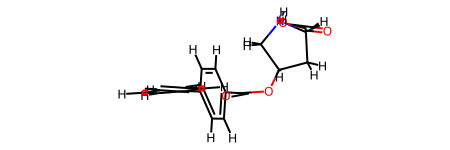

In [25]:
# Check our molecule from RDKit. Doesn't have rotation, but its neat to see in a Jupyer Notebook for just invoking it
corrected_pose_with_H

In [ ]:
## Creating tautomers
#from rdkit.Chem.MolStandardize import rdMolStandardize
# Initialize enumerator
#tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
# Provide RDKit Mol object to generate.
# We already made this, but you may start from a SMILE string or other source
# Remember, use the structure with implicit hydrogens!
#tautomers = tautomer_enumerator.Enumerate(corrected_pose)
# Take the TautomerEnumerationResults object and iterate over to get a list of structures
#tautomers_list = [t for t in tautomers]

'''
Note! This may generate duplicate structures,
You may want to cast these Mol objects into SMILES strings, de-duplicate,
then rebuild the Mol objects to map their coordinates back onto the reference structure
'''

# Cast to a set to make unique, then back to a list (as some tautomers can be enumerated again for some structures)
#smiles_set_tautomers = set(Chem.MolToSmiles(t) for t in tautomers_list)
#tautomer_list_unique = list(smiles_set_tautomers)
# We know the ligand structure does have unique tautomers, this is just a sanity check
#assert len(tautomers_list) == len(tautomer_list_unique)

In [ ]:
#len(tautomers)

In [ ]:
#ligand_tautomers = f"{ligand_directory}/{ligand_id}_tautomers.sdf"
#writer = Chem.SDWriter(ligand_tautomers)
#for t in tautomers_list:
#  writer.write(t)
#writer.close()

In [ ]:
#for t in tautomer_list_unique:
#  print(t)

In [ ]:
#from rdkit.Chem import Draw
#Draw.MolsToGridImage([Chem.MolFromSmiles(t) for t in tautomer_list_unique])

In [26]:
print(f"{ligand_directory}/{ligand_id}_corrected_pose.sdf")
print(f"{ligand_directory}/{ligand_id}.pdbqt")

ligand_structures/TJ5_corrected_pose.sdf
ligand_structures/TJ5.pdbqt


In [27]:
from rdkit import Chem
from scrubber import Scrub

In [28]:
!scrub.py ligand_structures/TJ5_corrected_pose.sdf -o ligand_structures/TJ5.sdf
#!scrub.py ligand_structures/ADP_corrected_pose.sdf -o ligand_structures/ADP.sdf

Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)


In [29]:
# Create our PDBQT to keep our hydrogens
ligand_pdbqt_filename = f"{ligand_directory}/{ligand_id}.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_pdbqt_filename} -xh")

0

In [ ]:
# Voila! The ligand is ready for docking!

## Preparing multiple ligands from SMILES strings

In [34]:
# Load the SMILES strings into RDKit and write back out an SDF file.

# Default delimiter is tab (\t), so we need to specify ","
smiles_supplier = Chem.SmilesMolSupplier("test2.csv", delimiter=",")
mols = []  # Could do this in list comprehension, adding a sanity check
for mol in smiles_supplier:
  print(Chem.MolToSmiles(mol))  # Sanity check that we got the smiles strings and not metadata
  mols.append(mol)

# Write out our molecules
ligands_to_dock_dirty = f"{ligand_directory}/ligands_to_dock_dirty.sdf"
writer = Chem.SDWriter(ligands_to_dock_dirty)
for m in mols:
  writer.write(m)
writer.close()

O=C(O[C@@H]1C[NH2+][C@H](C(=O)[O-])C1)c1ccc(-c2ccccc2)cc1
Cc1cccc(COc2ccccc2CN(CC[C@@H](N)C(=O)O)Cc2ccccc2OCc2cccc(C)c2)c1
Cc1cccc(COc2cccc3c2CN(CC[C@@H](N)C(=O)O)Cc2c(OCc4cccc(C)c4)cccc2-3)c1
COc1cccc2c1CN(CC[C@@H](N)C(=O)O)Cc1c(OC)cccc1-2


[13:20:28] WARNING: no name column found on line 1
[13:20:28] WARNING: no name column found on line 2
[13:20:28] WARNING: no name column found on line 3
[13:20:28] WARNING: no name column found on line 4


In [35]:
!scrub.py ligand_structures/ligands_to_dock_dirty.sdf -o ligand_structures/ligands_to_dock.sdf

Scrub completed.
Summary of what happened:
Input molecules supplied: 4
mols processed: 4, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 4 (avg. 1.000 per mol)
nr conformers:  4 (avg. 1.000 per isomer, 1.000 per mol)


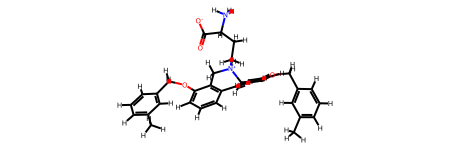

In [36]:
# Sanity check we got a structure with hydrogens
# RDKit automatically removes hydrogens by default (needed for most of the kit to work)
# But we're explicitly looking for them here, we can just load them and check
supplier = Chem.SDMolSupplier(f"{ligand_directory}/ligands_to_dock.sdf", removeHs=False)
reloaded_ligands = [mol for mol in supplier]
# The last structure will be the same as the last in list comprehension above
reloaded_ligands[-1]

# Visualization tool py3Dmol

In [33]:
import py3Dmol

# Compare the two ligand models
v = py3Dmol.view()
v.addModel(open(f"{ligand_directory}/{ligand_id}_fromPDB.pdb").read())
v.addModel(open(f"{ligand_corrected_pose_file}").read())
#v.setStyle()
v.setStyle({"model":0}, {'stick': {'color': '#0e9674'}})
v.setStyle({"model":1}, {'stick': {'color': '#c46225'}})
v.zoomTo({'model':0})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Voila! The ligands are ready for docking!